In [1]:
import datasets
ds = datasets.load_from_disk("./taco_cleaned_exec_filtered_max20")
ds

/home/elleven/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['question', 'solutions', 'starter_code', 'input_output', 'difficulty', 'raw_tags', 'name', 'source', 'tags', 'skill_types', 'url', 'Expected Auxiliary Space', 'time_limit', 'date', 'picture_num', 'memory_limit', 'Expected Time Complexity'],
    num_rows: 7126
})

/tmp/ipykernel_3063902/1836466.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)


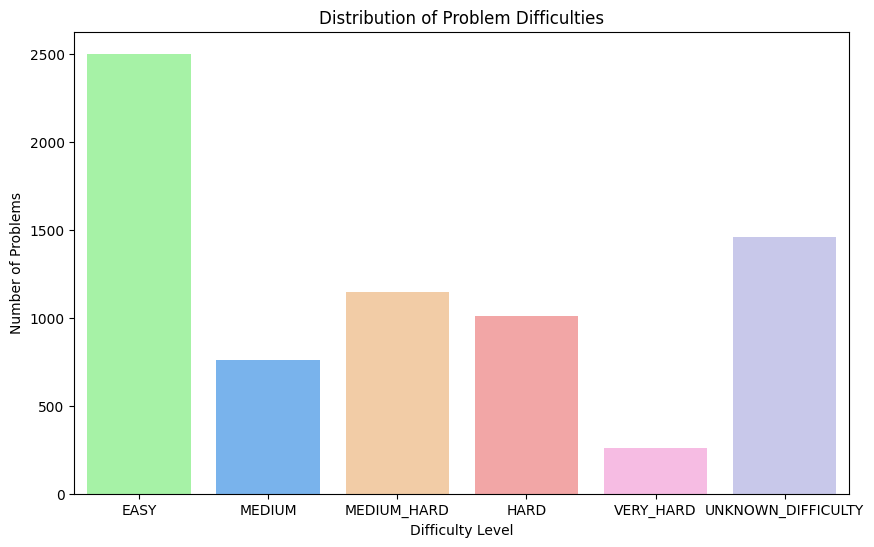

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dataset to pandas DataFrame
df = ds.to_pandas()

# Count the occurrences of each difficulty
difficulty_counts = df['difficulty'].value_counts()

# Define a specific order for the difficulties
order = ['EASY', 'MEDIUM', 'MEDIUM_HARD', 'HARD', 'VERY_HARD', 'UNKNOWN_DIFFICULTY']

# Filter and order the counts based on the defined order
ordered_difficulty_counts = pd.Series([difficulty_counts.get(level, 0) for level in order], index=order)

# Define colors, corresponding to the order
colors = ['#99ff99', '#66b3ff', '#ffcc99', '#ff9999', '#ffb3e6', '#c2c2f0']

plt.figure(figsize=(10, 6))
sns.barplot(x=ordered_difficulty_counts.index, y=ordered_difficulty_counts.values, palette=colors)
plt.title('Distribution of Problem Difficulties')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Problems')
plt.show()
plt.savefig("./plots/diff_distr.png")
plt.savefig("./plots/diff_distr.pdf")

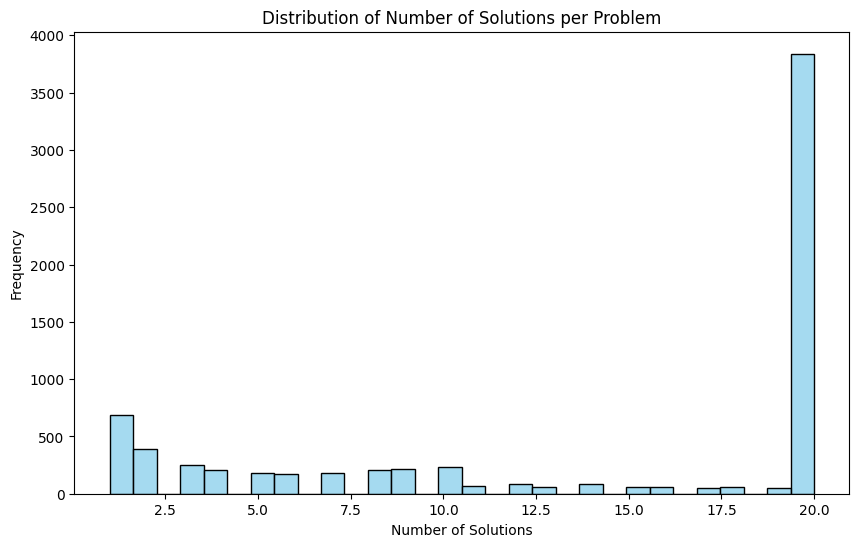

<Figure size 640x480 with 0 Axes>

In [4]:
# Count number of solutions per problem
num_solutions = ds.to_pandas()['solutions'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(num_solutions, bins=30, color='skyblue')
plt.title('Distribution of Number of Solutions per Problem')
plt.xlabel('Number of Solutions')
plt.ylabel('Frequency')
plt.show()
plt.savefig("./plots/distr_solutions.png")
plt.savefig("./plots/distr_solutions.pdf")

Calculating BLEU Scores: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 7126/7126 [02:59<00:00, 39.72it/s]


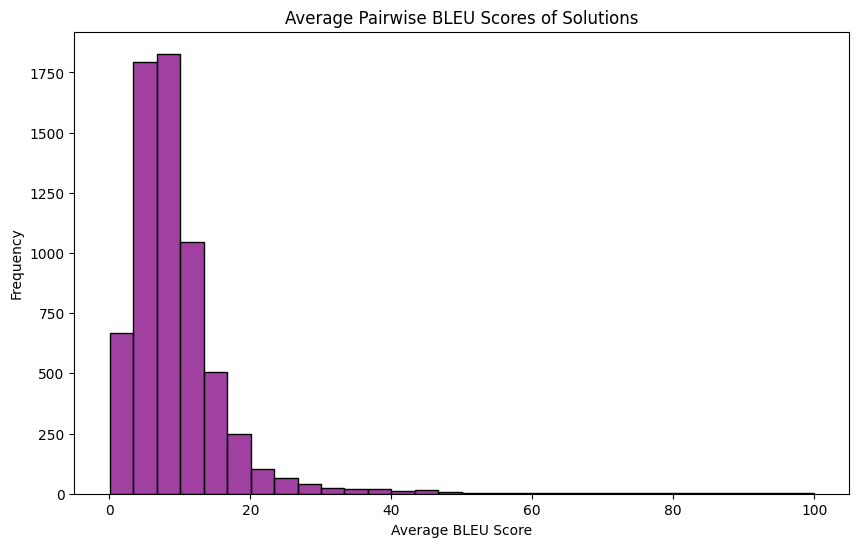

In [2]:
import sacrebleu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas(desc="Calculating BLEU Scores")

# Function to calculate the average BLEU score for all pairwise comparisons within each list of solutions
def average_bleu_scores(solutions):
    if len(solutions) < 2:
        return np.nan  # Not enough data to calculate BLEU
    scores = []
    # Compare each pair of solutions
    for i in range(len(solutions)):
        for j in range(i + 1, len(solutions)):
            reference = solutions[i]
            candidate = solutions[j]
            # Calculate BLEU score and append to list
            score = sacrebleu.raw_corpus_bleu([candidate], [[reference]], .01).score
            scores.append(score)
    # Return average of all calculated BLEU scores
    return np.mean(scores)

# Assuming 'ds' is your dataset variable and has been loaded correctly
df = ds.to_pandas()

# Apply the BLEU score calculation function
df['bleu_scores'] = df['solutions'].progress_apply(average_bleu_scores)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(df['bleu_scores'].dropna(), bins=30, color='purple')
plt.title('Average Pairwise BLEU Scores of Solutions')
plt.xlabel('Average BLEU Score')
plt.ylabel('Frequency')
plt.show()

In [3]:
plt.savefig("./plots/bleu_between_solutions.png")
plt.savefig("./plots/bleu_between_solutions.pdf")

<Figure size 640x480 with 0 Axes>

In [5]:
total_solns = 0
for ex in ds:
    total_solns += len(ex["solutions"])

total_solns

97320

Tokenizing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7126/7126 [00:36<00:00, 197.47it/s]


Minimum token length: 6
Maximum token length: 4096
Mean token length: 215.317663378545
Median token length: 155.0


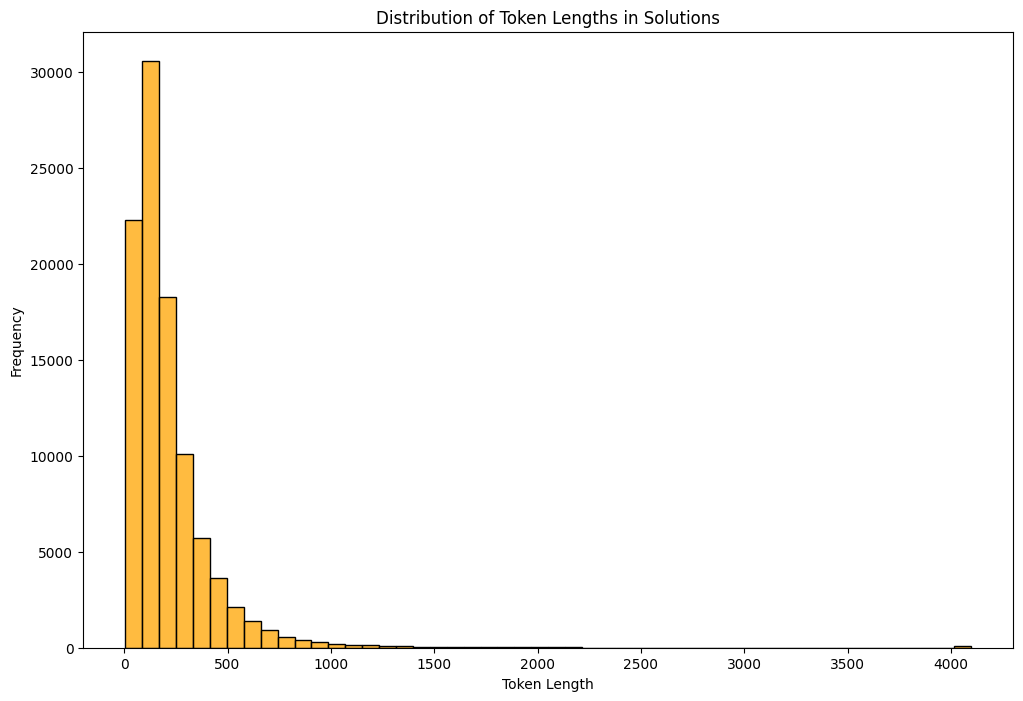

In [11]:
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

tqdm.pandas(desc="Tokenizing")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-15b")

# Function to tokenize solutions and return token lengths
def get_token_lengths(solutions):
    token_lengths = []
    for solution in solutions:
        tokens = tokenizer.encode(solution, truncation=True, max_length=4096)
        token_lengths.append(len(tokens))
    return token_lengths

# Apply function to each list of solutions and flatten the result
all_token_lengths = [length for sublist in ds.to_pandas()['solutions'].progress_apply(get_token_lengths) for length in sublist]

# Convert to DataFrame for easier handling
token_lengths_df = pd.DataFrame(all_token_lengths, columns=['Token Lengths'])

# Basic statistics
min_length = token_lengths_df['Token Lengths'].min()
max_length = token_lengths_df['Token Lengths'].max()
mean_length = token_lengths_df['Token Lengths'].mean()
median_length = token_lengths_df['Token Lengths'].median()

print(f"Minimum token length: {min_length}")
print(f"Maximum token length: {max_length}")
print(f"Mean token length: {mean_length}")
print(f"Median token length: {median_length}")

# Plotting the distribution of token lengths
plt.figure(figsize=(12, 8))
sns.histplot(token_lengths_df['Token Lengths'], bins=50, color='orange')
plt.title('Distribution of Token Lengths in Solutions')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()